# Steered MD in BioSimSpace

Now that all of the required seeded MD simulations have run, we can use the trajectory data to construct a Markov State Model (MSM). [PyEMMA] (http://emma-project.org/latest/) is a python library for this, and has their own [tutorials] (http://emma-project.org/latest/tutorial.html). This notebook quickly illustrates how to load data from simulations carried out with BioSimSpace, which can then be used for model building.

In [2]:
import pyemma
import os
import mdtraj as md
import numpy as np

## Get all trajectories

Loading all the trajectories would require more memory than available for most workstations. Instead we will ind all the trajectories that will be used and create a stream reader.

In [3]:
source_dir = '/home/adele/Documents/PTP1B-open-peptide_BSS'

In [4]:
files = []
for i in range(20):
    files.append(f'{source_dir}/seeded/snapshot_{i+1}/production_dry.nc')

## Featurize

MSMs do not use all atom coordinates, but requires dimensionality reduction. Here RMSD to open WPD loop conformation and distance between a catalytic residue and the substrate will be used. We create a featuriser object to do this.

In [5]:
feat = pyemma.coordinates.featurizer(f'{source_dir}/system-setup/system_dry.prm7')
rmsd_reference = md.load('/home/adele/Documents/preparing-ptp1b/visualization/ptp1b-open_truncated.pdb')
indices = []
for atom in rmsd_reference.top.atoms:
    if not atom.name.startswith('H') and 178<=atom.residue.index<=184:
        indices.append(atom.index)
feat.add_minrmsd_to_ref(rmsd_reference, atom_indices=indices)
substrate_distance = feat.pairs(feat.select('(resid 215 and name SG) or (resname PTR and name P)'))
feat.add_distances(substrate_distance)

## Load data

Then we create our trajectory reader and get the reduced data, which is the values of RMSD and distance for each frame of each simulation.

In [6]:
trajectories = pyemma.coordinates.source(files, feat)

Obtaining file info:   0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
data = trajectories.get_output()

getting output of FeatureReader:   0%|          | 0/20 [00:00<?, ?it/s]

In [9]:
data

[array([[0.2617052 , 0.50614816],
        [0.2521226 , 0.51235414],
        [0.263818  , 0.49899533],
        ...,
        [0.2941338 , 0.5791968 ],
        [0.3001721 , 0.6085965 ],
        [0.28907034, 0.5828696 ]], dtype=float32),
 array([[0.24496937, 0.5179444 ],
        [0.23971172, 0.5155687 ],
        [0.24117406, 0.5280065 ],
        ...,
        [0.24857913, 0.7953518 ],
        [0.23537804, 0.74935496],
        [0.24255018, 0.7605438 ]], dtype=float32),
 array([[0.24628864, 0.5255806 ],
        [0.25265345, 0.51832765],
        [0.26094913, 0.53216827],
        ...,
        [0.25197074, 0.74272835],
        [0.24914615, 0.7391892 ],
        [0.2541253 , 0.72082055]], dtype=float32),
 array([[0.24819015, 0.547639  ],
        [0.23961127, 0.5071759 ],
        [0.24521719, 0.5292086 ],
        ...,
        [0.26021403, 0.5753224 ],
        [0.2642792 , 0.5671076 ],
        [0.2512782 , 0.5900365 ]], dtype=float32),
 array([[0.24743587, 0.51575905],
        [0.2402961 , 0.5038547

## Plot

We can plot the data:

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='Feature values'>)

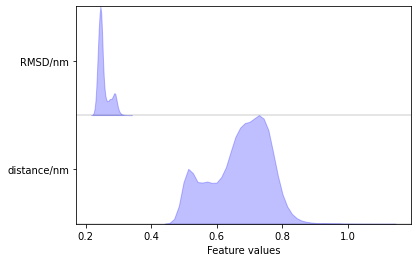

In [10]:
pyemma.plots.plot_feature_histograms(np.vstack(data), feature_labels=['RMSD/nm', 'distance/nm'])

Text(0, 0.5, 'distance/nm')

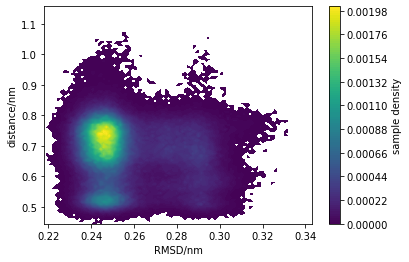

In [11]:
fig, ax, misc = pyemma.plots.plot_density(np.vstack(data)[:,0], np.vstack(data)[:,1])
ax.set_xlabel('RMSD/nm')
ax.set_ylabel('distance/nm')

At this point our steered MD simulation has been used to sample a wide range of conformational space. The trajectory data from seeded MD runs has been reduced to important features only and is ready to be used in building an MSM.